In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crypto/price_history_data.jsonl
/kaggle/input/crypto/training_data.jsonl
/kaggle/input/crypto/BTC_test_price.jsonl
/kaggle/input/crypto/BTC_test_news.jsonl
/kaggle/input/crypto/requirements.txt


In [2]:
!pip install -r /kaggle/input/crypto/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 52.1 MB/s eta 0:00:00:00:010:01m


In [3]:
import faiss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import torch
from torch import nn
from transformers import BertModel, BertTokenizer
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import json
import os

In [4]:
# Path to your folder containing .jsonl files
folder_path = r"/kaggle/input/crypto/"

# Initialize an empty list to store the dictionaries from all files
price_history_data_list = []

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('price_history_data.jsonl'):
        file_path = os.path.join(folder_path, filename)

        # Open and read each file
        with open(file_path, 'r') as file:
            for line in file:
                # Convert each line into a dictionary and append to the list
                price_history_data_list.append(json.loads(line))

price_history_data = {}

In [5]:
price_history_data_list[0]

{'currency': 'BTC',
 'month_year': '2019-09',
 'data': {'this_month_price': 10238.554568886,
  'next_month_price': 8269.028681584,
  'percentage_change': -0.19236366559857992}}

In [6]:
for entry in price_history_data_list:
    if entry['currency'] not in price_history_data:
        price_history_data[entry['currency']]={}
    price_history_data[entry['currency']][entry['month_year']] = {
        'this_month_price': entry['data']['this_month_price'],
        'next_month_price': entry['data']['next_month_price'],
        'percentage_change': entry['data']['percentage_change'],
    }

In [7]:
file_path = r'/kaggle/input/crypto/training_data.jsonl'

# Initialize an empty list to store the dictionaries
training_data_list = []

# Open the file and read line by line
with open(file_path, 'r') as file:
    for line in file:
        # Convert each line into a dictionary and append to the list
        training_data_list.append(json.loads(line))

training_data = {}

for entry in training_data_list:
    if entry['currency'] not in training_data:
        training_data[entry['currency']] = {}
    training_data[entry['currency']][entry['month_year']] = entry['data']

In [8]:
texts=[]
targets=[]

In [9]:
for ticker in price_history_data.keys():
    if ticker in training_data:
        for month_year in price_history_data[ticker].keys():
            if month_year in training_data[ticker]:
                headline=[i['title'] for i in training_data[ticker][month_year]]
                texts.append(headline)
                target=price_history_data[ticker][month_year]['percentage_change']
                targets.append(target)

In [10]:
# Randomly split the dataset into train and test sets for texts, targets, and vectors
train_texts, test_texts, train_targets, test_targets = train_test_split(
    texts, targets,test_size=0.1, random_state=42
)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
class FinBERTRegressor(nn.Module):
    def __init__(self, finbert_model_name="ProsusAI/finbert", hidden_size=768, output_size=1):
        super(FinBERTRegressor, self).__init__()
        self.finbert = BertModel.from_pretrained(finbert_model_name)
        # Regression layer
        self.regressor = nn.Linear(hidden_size, output_size)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        with torch.no_grad():  # No need to calculate gradients for FinBERT
            outputs = self.finbert(input_ids=input_ids, attention_mask=attention_mask)

        # We use the [CLS] token's embedding for regression
        cls_embedding = outputs.last_hidden_state[:, 0, :]

        # Pass through the regression layer
        return self.regressor(cls_embedding)

In [13]:
model=FinBERTRegressor()
model.to(device)

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

FinBERTRegressor(
  (finbert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [14]:
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [15]:
train_input_ids = []
train_attention_masks = []

In [16]:
for group_text in tqdm(train_texts, desc="Tokenizing"):
    text = ". ".join(group_text) + "."
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=64,
                        pad_to_max_length=True,
                        return_attention_mask=True,
                        return_tensors='pt',
                   )

    train_input_ids.append(encoded_dict['input_ids'])
    train_attention_masks.append(encoded_dict['attention_mask'])

Tokenizing:   0%|          | 0/4708 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Tokenizing: 100%|██████████| 4708/4708 [01:01<0

In [17]:
train_input_ids=torch.cat(train_input_ids,dim=0)
train_attention_masks=torch.cat(train_attention_masks,dim=0)

In [18]:
train_targets=torch.tensor(train_targets)

In [19]:
train_targets.size()

torch.Size([4708])

In [20]:
#Create Tensor Dataset
dataset=TensorDataset(train_input_ids,train_attention_masks,train_targets)
#Dataloader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

#### Preprocess test data in the same way

In [21]:
test_input_ids = []
test_attention_masks = []

for group_text in tqdm(test_texts, desc="Tokenizing Test Data"):
    text = ". ".join(group_text) + "."
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=64,
                        pad_to_max_length=True,
                        return_attention_mask=True,
                        return_tensors='pt',
                   )

    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_targets = torch.tensor(test_targets)

# Create TensorDataset for test data
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_targets)

# Create DataLoader for test data
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Tokenizing Test Data: 100%|██████████| 524/524 [00:06<00:00, 77.11it/s] 


### Training

In [22]:
avg_train_loss_history = []
avg_test_loss_history = []
avg_train_rmse_history, avg_test_rmse_history = [], []
best_test_loss = float('inf')
best_epoch = 0
start_epoch=1
end_epoch=51

In [23]:
model_dir = 'model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [24]:
def calculate_rmse(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE)
    """
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

In [25]:
for epoch in range(start_epoch, end_epoch):
    # Training Phase
    model.train()
    total_train_loss = 0
    total_train_rmse = 0
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch}/{end_epoch - 1}')
    for batch in progress_bar:
        b_input_ids, b_input_mask, b_labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        outputs = model(b_input_ids, b_input_mask)
        loss = loss_fn(outputs.squeeze(), b_labels.float())
        total_train_loss += loss.item()
        batch_rmse = calculate_rmse(b_labels, outputs)
        total_train_rmse += batch_rmse.item()
        loss.backward()
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch}/{end_epoch} - Train Loss: {loss.item():.2f}, RMSE: {batch_rmse.item():.2f}")

    avg_train_loss = total_train_loss / len(dataloader)
    avg_train_rmse = total_train_rmse / len(dataloader)
    avg_train_loss_history.append(avg_train_loss)
    avg_train_rmse_history.append(avg_train_rmse)
    print(f'Epoch {epoch}/{end_epoch} - Avg Train Loss: {avg_train_loss:.2f}, Avg Train RMSE: {avg_train_rmse:.2f}')
    
    # Evaluation Phase
    model.eval()
    total_test_loss = 0
    total_test_rmse = 0 
    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids, b_input_mask, b_labels = [b.to(device) for b in batch]
            outputs = model(b_input_ids, b_input_mask)
            loss = loss_fn(outputs.squeeze(), b_labels.float())
            total_test_loss += loss.item()
            batch_rmse = calculate_rmse(b_labels, outputs)
            total_test_rmse += batch_rmse.item()

    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_rmse = total_test_rmse / len(dataloader)
    avg_test_loss_history.append(avg_test_loss)
    avg_test_rmse_history.append(avg_test_rmse)
    print(f'Epoch {epoch}/{end_epoch} - Avg Test Loss: {avg_test_loss:.2f}, Avg Test RMSE: {avg_test_rmse:.2f}')

    # Keep track of the best epoch
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_epoch = epoch

    # Save the model weights
    model_save_path = os.path.join(model_dir, f'model_epoch_{epoch}.pth')
    torch.save(model.regressor.state_dict(), model_save_path)
    print(f'Model saved for epoch {epoch} at {model_save_path}')

Epoch 1/51 - Train Loss: 0.04, RMSE: 0.17: 100%|██████████| 148/148 [00:08<00:00, 17.02it/s] 


Epoch 1/51 - Avg Train Loss: 0.65, Avg Train RMSE: 0.63
Epoch 1/51 - Avg Test Loss: 0.23, Avg Test RMSE: 0.06
Model saved for epoch 1 at model/model_epoch_1.pth


Epoch 2/51 - Train Loss: 0.08, RMSE: 0.24: 100%|██████████| 148/148 [00:08<00:00, 18.19it/s] 


Epoch 2/51 - Avg Train Loss: 0.58, Avg Train RMSE: 0.55
Epoch 2/51 - Avg Test Loss: 0.21, Avg Test RMSE: 0.05
Model saved for epoch 2 at model/model_epoch_2.pth


Epoch 3/51 - Train Loss: 0.05, RMSE: 0.34: 100%|██████████| 148/148 [00:08<00:00, 18.20it/s]


Epoch 3/51 - Avg Train Loss: 0.56, Avg Train RMSE: 0.55
Epoch 3/51 - Avg Test Loss: 0.21, Avg Test RMSE: 0.05
Model saved for epoch 3 at model/model_epoch_3.pth


Epoch 4/51 - Train Loss: 0.01, RMSE: 0.16: 100%|██████████| 148/148 [00:08<00:00, 18.16it/s]


Epoch 4/51 - Avg Train Loss: 0.56, Avg Train RMSE: 0.56
Epoch 4/51 - Avg Test Loss: 0.21, Avg Test RMSE: 0.05
Model saved for epoch 4 at model/model_epoch_4.pth


Epoch 5/51 - Train Loss: 0.09, RMSE: 0.32: 100%|██████████| 148/148 [00:08<00:00, 18.11it/s]


Epoch 5/51 - Avg Train Loss: 0.56, Avg Train RMSE: 0.55
Epoch 5/51 - Avg Test Loss: 0.21, Avg Test RMSE: 0.05
Model saved for epoch 5 at model/model_epoch_5.pth


Epoch 6/51 - Train Loss: 0.15, RMSE: 0.42: 100%|██████████| 148/148 [00:08<00:00, 18.08it/s] 


Epoch 6/51 - Avg Train Loss: 0.56, Avg Train RMSE: 0.55
Epoch 6/51 - Avg Test Loss: 0.21, Avg Test RMSE: 0.05
Model saved for epoch 6 at model/model_epoch_6.pth


Epoch 7/51 - Train Loss: 0.33, RMSE: 0.53: 100%|██████████| 148/148 [00:08<00:00, 18.12it/s]


Epoch 7/51 - Avg Train Loss: 0.56, Avg Train RMSE: 0.55
Epoch 7/51 - Avg Test Loss: 0.21, Avg Test RMSE: 0.05
Model saved for epoch 7 at model/model_epoch_7.pth


Epoch 8/51 - Train Loss: 0.24, RMSE: 0.50: 100%|██████████| 148/148 [00:08<00:00, 18.10it/s]


Epoch 8/51 - Avg Train Loss: 0.56, Avg Train RMSE: 0.55
Epoch 8/51 - Avg Test Loss: 0.21, Avg Test RMSE: 0.05
Model saved for epoch 8 at model/model_epoch_8.pth


Epoch 9/51 - Train Loss: 0.04, RMSE: 0.26: 100%|██████████| 148/148 [00:08<00:00, 18.14it/s]


Epoch 9/51 - Avg Train Loss: 0.55, Avg Train RMSE: 0.55
Epoch 9/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 9 at model/model_epoch_9.pth


Epoch 10/51 - Train Loss: 0.26, RMSE: 0.41: 100%|██████████| 148/148 [00:08<00:00, 18.14it/s] 


Epoch 10/51 - Avg Train Loss: 0.56, Avg Train RMSE: 0.55
Epoch 10/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 10 at model/model_epoch_10.pth


Epoch 11/51 - Train Loss: 0.05, RMSE: 0.25: 100%|██████████| 148/148 [00:08<00:00, 18.04it/s] 


Epoch 11/51 - Avg Train Loss: 0.56, Avg Train RMSE: 0.55
Epoch 11/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 11 at model/model_epoch_11.pth


Epoch 12/51 - Train Loss: 0.17, RMSE: 0.47: 100%|██████████| 148/148 [00:08<00:00, 18.08it/s] 


Epoch 12/51 - Avg Train Loss: 0.56, Avg Train RMSE: 0.55
Epoch 12/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 12 at model/model_epoch_12.pth


Epoch 13/51 - Train Loss: 0.14, RMSE: 0.36: 100%|██████████| 148/148 [00:08<00:00, 18.10it/s]


Epoch 13/51 - Avg Train Loss: 0.55, Avg Train RMSE: 0.55
Epoch 13/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 13 at model/model_epoch_13.pth


Epoch 14/51 - Train Loss: 0.08, RMSE: 0.28: 100%|██████████| 148/148 [00:08<00:00, 18.11it/s]


Epoch 14/51 - Avg Train Loss: 0.55, Avg Train RMSE: 0.55
Epoch 14/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 14 at model/model_epoch_14.pth


Epoch 15/51 - Train Loss: 0.17, RMSE: 0.41: 100%|██████████| 148/148 [00:08<00:00, 18.11it/s]


Epoch 15/51 - Avg Train Loss: 0.56, Avg Train RMSE: 0.55
Epoch 15/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 15 at model/model_epoch_15.pth


Epoch 16/51 - Train Loss: 0.12, RMSE: 0.41: 100%|██████████| 148/148 [00:08<00:00, 18.12it/s]


Epoch 16/51 - Avg Train Loss: 0.56, Avg Train RMSE: 0.55
Epoch 16/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 16 at model/model_epoch_16.pth


Epoch 17/51 - Train Loss: 0.15, RMSE: 0.34: 100%|██████████| 148/148 [00:08<00:00, 18.11it/s]


Epoch 17/51 - Avg Train Loss: 0.55, Avg Train RMSE: 0.55
Epoch 17/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 17 at model/model_epoch_17.pth


Epoch 18/51 - Train Loss: 0.05, RMSE: 0.34: 100%|██████████| 148/148 [00:08<00:00, 18.02it/s]


Epoch 18/51 - Avg Train Loss: 0.55, Avg Train RMSE: 0.55
Epoch 18/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 18 at model/model_epoch_18.pth


Epoch 19/51 - Train Loss: 0.06, RMSE: 0.20: 100%|██████████| 148/148 [00:08<00:00, 18.04it/s]


Epoch 19/51 - Avg Train Loss: 0.55, Avg Train RMSE: 0.55
Epoch 19/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 19 at model/model_epoch_19.pth


Epoch 20/51 - Train Loss: 0.09, RMSE: 0.24: 100%|██████████| 148/148 [00:08<00:00, 18.03it/s] 


Epoch 20/51 - Avg Train Loss: 0.55, Avg Train RMSE: 0.55
Epoch 20/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 20 at model/model_epoch_20.pth


Epoch 21/51 - Train Loss: 0.24, RMSE: 0.54: 100%|██████████| 148/148 [00:08<00:00, 18.07it/s]


Epoch 21/51 - Avg Train Loss: 0.55, Avg Train RMSE: 0.54
Epoch 21/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 21 at model/model_epoch_21.pth


Epoch 22/51 - Train Loss: 0.23, RMSE: 0.37: 100%|██████████| 148/148 [00:08<00:00, 18.05it/s]


Epoch 22/51 - Avg Train Loss: 0.55, Avg Train RMSE: 0.55
Epoch 22/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 22 at model/model_epoch_22.pth


Epoch 23/51 - Train Loss: 3.01, RMSE: 1.74: 100%|██████████| 148/148 [00:08<00:00, 18.10it/s]


Epoch 23/51 - Avg Train Loss: 0.57, Avg Train RMSE: 0.55
Epoch 23/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 23 at model/model_epoch_23.pth


Epoch 24/51 - Train Loss: 0.04, RMSE: 0.20: 100%|██████████| 148/148 [00:08<00:00, 18.06it/s] 


Epoch 24/51 - Avg Train Loss: 0.55, Avg Train RMSE: 0.55
Epoch 24/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 24 at model/model_epoch_24.pth


Epoch 25/51 - Train Loss: 0.22, RMSE: 0.44: 100%|██████████| 148/148 [00:08<00:00, 18.04it/s]


Epoch 25/51 - Avg Train Loss: 0.55, Avg Train RMSE: 0.55
Epoch 25/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 25 at model/model_epoch_25.pth


Epoch 26/51 - Train Loss: 0.14, RMSE: 0.34: 100%|██████████| 148/148 [00:08<00:00, 18.07it/s]


Epoch 26/51 - Avg Train Loss: 0.54, Avg Train RMSE: 0.54
Epoch 26/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 26 at model/model_epoch_26.pth


Epoch 27/51 - Train Loss: 0.03, RMSE: 0.19: 100%|██████████| 148/148 [00:08<00:00, 18.05it/s]


Epoch 27/51 - Avg Train Loss: 0.55, Avg Train RMSE: 0.54
Epoch 27/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 27 at model/model_epoch_27.pth


Epoch 28/51 - Train Loss: 0.18, RMSE: 0.47: 100%|██████████| 148/148 [00:08<00:00, 18.07it/s]


Epoch 28/51 - Avg Train Loss: 0.55, Avg Train RMSE: 0.54
Epoch 28/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 28 at model/model_epoch_28.pth


Epoch 29/51 - Train Loss: 0.27, RMSE: 0.61: 100%|██████████| 148/148 [00:08<00:00, 18.09it/s]


Epoch 29/51 - Avg Train Loss: 0.55, Avg Train RMSE: 0.55
Epoch 29/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 29 at model/model_epoch_29.pth


Epoch 30/51 - Train Loss: 0.05, RMSE: 0.26: 100%|██████████| 148/148 [00:08<00:00, 18.08it/s]


Epoch 30/51 - Avg Train Loss: 0.55, Avg Train RMSE: 0.54
Epoch 30/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 30 at model/model_epoch_30.pth


Epoch 31/51 - Train Loss: 0.02, RMSE: 0.19: 100%|██████████| 148/148 [00:08<00:00, 18.09it/s]


Epoch 31/51 - Avg Train Loss: 0.54, Avg Train RMSE: 0.54
Epoch 31/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 31 at model/model_epoch_31.pth


Epoch 32/51 - Train Loss: 0.27, RMSE: 0.50: 100%|██████████| 148/148 [00:08<00:00, 18.08it/s] 


Epoch 32/51 - Avg Train Loss: 0.54, Avg Train RMSE: 0.54
Epoch 32/51 - Avg Test Loss: 0.20, Avg Test RMSE: 0.05
Model saved for epoch 32 at model/model_epoch_32.pth


Epoch 33/51 - Train Loss: 0.01, RMSE: 0.16: 100%|██████████| 148/148 [00:08<00:00, 18.10it/s]


Epoch 33/51 - Avg Train Loss: 0.54, Avg Train RMSE: 0.54
Epoch 33/51 - Avg Test Loss: 0.19, Avg Test RMSE: 0.05
Model saved for epoch 33 at model/model_epoch_33.pth


Epoch 34/51 - Train Loss: 0.03, RMSE: 0.21: 100%|██████████| 148/148 [00:08<00:00, 18.04it/s]


Epoch 34/51 - Avg Train Loss: 0.55, Avg Train RMSE: 0.54
Epoch 34/51 - Avg Test Loss: 0.19, Avg Test RMSE: 0.05
Model saved for epoch 34 at model/model_epoch_34.pth


Epoch 35/51 - Train Loss: 0.03, RMSE: 0.23: 100%|██████████| 148/148 [00:08<00:00, 18.08it/s]


Epoch 35/51 - Avg Train Loss: 0.54, Avg Train RMSE: 0.54
Epoch 35/51 - Avg Test Loss: 0.19, Avg Test RMSE: 0.05
Model saved for epoch 35 at model/model_epoch_35.pth


Epoch 36/51 - Train Loss: 0.01, RMSE: 0.23: 100%|██████████| 148/148 [00:08<00:00, 18.07it/s]


Epoch 36/51 - Avg Train Loss: 0.54, Avg Train RMSE: 0.54
Epoch 36/51 - Avg Test Loss: 0.19, Avg Test RMSE: 0.05
Model saved for epoch 36 at model/model_epoch_36.pth


Epoch 37/51 - Train Loss: 0.02, RMSE: 0.21: 100%|██████████| 148/148 [00:08<00:00, 18.01it/s]


Epoch 37/51 - Avg Train Loss: 0.54, Avg Train RMSE: 0.54
Epoch 37/51 - Avg Test Loss: 0.19, Avg Test RMSE: 0.05
Model saved for epoch 37 at model/model_epoch_37.pth


Epoch 38/51 - Train Loss: 0.29, RMSE: 0.43: 100%|██████████| 148/148 [00:08<00:00, 18.05it/s]


Epoch 38/51 - Avg Train Loss: 0.55, Avg Train RMSE: 0.55
Epoch 38/51 - Avg Test Loss: 0.19, Avg Test RMSE: 0.05
Model saved for epoch 38 at model/model_epoch_38.pth


Epoch 39/51 - Train Loss: 0.08, RMSE: 0.28: 100%|██████████| 148/148 [00:08<00:00, 18.00it/s]


Epoch 39/51 - Avg Train Loss: 0.55, Avg Train RMSE: 0.54
Epoch 39/51 - Avg Test Loss: 0.19, Avg Test RMSE: 0.05
Model saved for epoch 39 at model/model_epoch_39.pth


Epoch 40/51 - Train Loss: 0.29, RMSE: 0.59: 100%|██████████| 148/148 [00:08<00:00, 18.05it/s]


Epoch 40/51 - Avg Train Loss: 0.54, Avg Train RMSE: 0.54
Epoch 40/51 - Avg Test Loss: 0.19, Avg Test RMSE: 0.05
Model saved for epoch 40 at model/model_epoch_40.pth


Epoch 41/51 - Train Loss: 0.02, RMSE: 0.24: 100%|██████████| 148/148 [00:08<00:00, 18.04it/s] 


Epoch 41/51 - Avg Train Loss: 0.54, Avg Train RMSE: 0.54
Epoch 41/51 - Avg Test Loss: 0.19, Avg Test RMSE: 0.05
Model saved for epoch 41 at model/model_epoch_41.pth


Epoch 42/51 - Train Loss: 0.07, RMSE: 0.26: 100%|██████████| 148/148 [00:08<00:00, 18.05it/s]


Epoch 42/51 - Avg Train Loss: 0.54, Avg Train RMSE: 0.54
Epoch 42/51 - Avg Test Loss: 0.19, Avg Test RMSE: 0.05
Model saved for epoch 42 at model/model_epoch_42.pth


Epoch 43/51 - Train Loss: 0.05, RMSE: 0.31: 100%|██████████| 148/148 [00:08<00:00, 18.09it/s]


Epoch 43/51 - Avg Train Loss: 0.54, Avg Train RMSE: 0.53
Epoch 43/51 - Avg Test Loss: 0.19, Avg Test RMSE: 0.05
Model saved for epoch 43 at model/model_epoch_43.pth


Epoch 44/51 - Train Loss: 0.07, RMSE: 0.28: 100%|██████████| 148/148 [00:08<00:00, 18.01it/s]


Epoch 44/51 - Avg Train Loss: 0.54, Avg Train RMSE: 0.54
Epoch 44/51 - Avg Test Loss: 0.19, Avg Test RMSE: 0.05
Model saved for epoch 44 at model/model_epoch_44.pth


Epoch 45/51 - Train Loss: 0.09, RMSE: 0.27: 100%|██████████| 148/148 [00:08<00:00, 18.09it/s]


Epoch 45/51 - Avg Train Loss: 0.54, Avg Train RMSE: 0.54
Epoch 45/51 - Avg Test Loss: 0.19, Avg Test RMSE: 0.05
Model saved for epoch 45 at model/model_epoch_45.pth


Epoch 46/51 - Train Loss: 0.00, RMSE: 0.16: 100%|██████████| 148/148 [00:08<00:00, 18.04it/s] 


Epoch 46/51 - Avg Train Loss: 0.54, Avg Train RMSE: 0.54
Epoch 46/51 - Avg Test Loss: 0.19, Avg Test RMSE: 0.05
Model saved for epoch 46 at model/model_epoch_46.pth


Epoch 47/51 - Train Loss: 0.05, RMSE: 0.17: 100%|██████████| 148/148 [00:08<00:00, 18.08it/s]


Epoch 47/51 - Avg Train Loss: 0.54, Avg Train RMSE: 0.54
Epoch 47/51 - Avg Test Loss: 0.19, Avg Test RMSE: 0.05
Model saved for epoch 47 at model/model_epoch_47.pth


Epoch 48/51 - Train Loss: 0.04, RMSE: 0.33: 100%|██████████| 148/148 [00:08<00:00, 18.08it/s] 


Epoch 48/51 - Avg Train Loss: 0.54, Avg Train RMSE: 0.54
Epoch 48/51 - Avg Test Loss: 0.19, Avg Test RMSE: 0.05
Model saved for epoch 48 at model/model_epoch_48.pth


Epoch 49/51 - Train Loss: 0.09, RMSE: 0.29: 100%|██████████| 148/148 [00:08<00:00, 18.05it/s] 


Epoch 49/51 - Avg Train Loss: 0.54, Avg Train RMSE: 0.54
Epoch 49/51 - Avg Test Loss: 0.19, Avg Test RMSE: 0.05
Model saved for epoch 49 at model/model_epoch_49.pth


Epoch 50/51 - Train Loss: 0.09, RMSE: 0.25: 100%|██████████| 148/148 [00:08<00:00, 18.06it/s]


Epoch 50/51 - Avg Train Loss: 0.54, Avg Train RMSE: 0.54
Epoch 50/51 - Avg Test Loss: 0.19, Avg Test RMSE: 0.05
Model saved for epoch 50 at model/model_epoch_50.pth


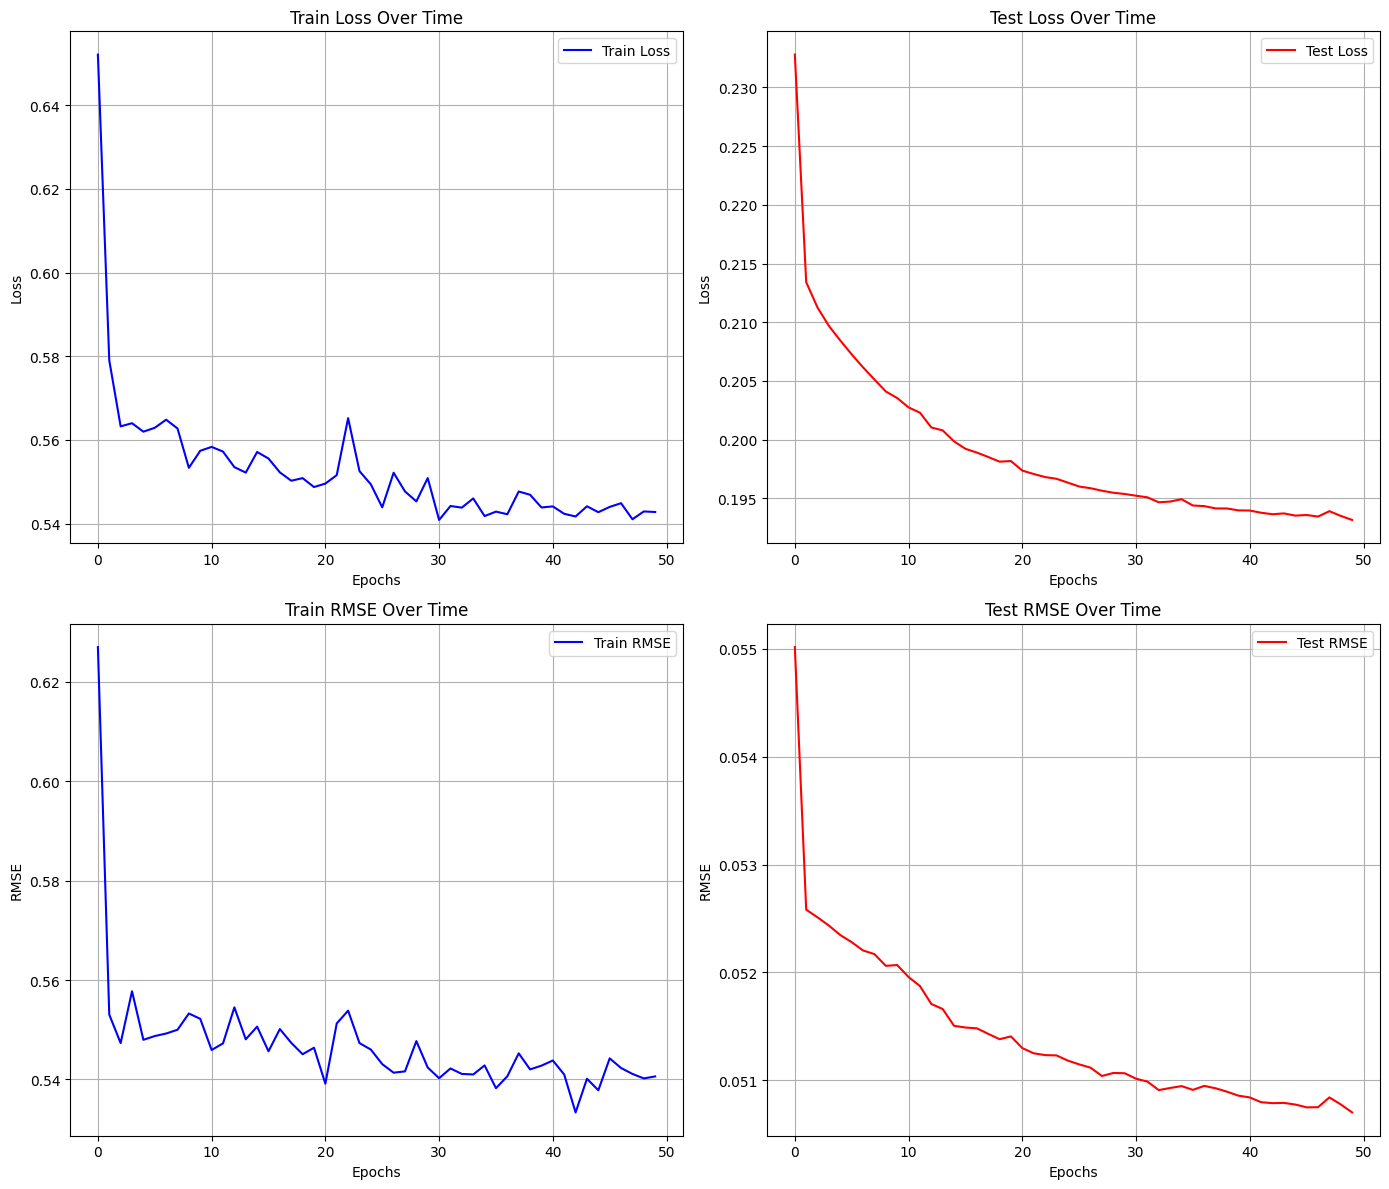

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# Plotting the first subplot: Train Loss
ax[0, 0].plot(avg_train_loss_history, linestyle='-', color='b', label='Train Loss')
ax[0, 0].set_title('Train Loss Over Time')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].legend(loc='upper right')
ax[0, 0].grid(True)

# Plotting the second subplot: Test Loss
ax[0, 1].plot(avg_test_loss_history, linestyle='-', color='r', label='Test Loss')
ax[0, 1].set_title('Test Loss Over Time')
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('Loss')
ax[0, 1].legend(loc='upper right')
ax[0, 1].grid(True)

# Plotting the third subplot: Train RMSE
ax[1, 0].plot(avg_train_rmse_history, linestyle='-', color='b', label='Train RMSE')
ax[1, 0].set_title('Train RMSE Over Time')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('RMSE')
ax[1, 0].legend(loc='upper right')
ax[1, 0].grid(True)

# Plotting the fourth subplot: Test RMSE
ax[1, 1].plot(avg_test_rmse_history, linestyle='-', color='r', label='Test RMSE')
ax[1, 1].set_title('Test RMSE Over Time')
ax[1, 1].set_xlabel('Epochs')
ax[1, 1].set_ylabel('RMSE')
ax[1, 1].legend(loc='upper right')
ax[1, 1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [27]:
print(f'Best epoch: {best_epoch} with Test Loss: {best_test_loss:.5f}')

Best epoch: 50 with Test Loss: 0.19315


In [28]:
print("Minimum Test Loss:",min(avg_test_loss_history))
print("Minimum Test RMSE:",min(avg_test_rmse_history))

Minimum Test Loss: 0.1931502376409138
Minimum Test RMSE: 0.05070368462317699


### Model Evaluation

#### Loading best model

In [30]:
model.regressor.load_state_dict(torch.load('/kaggle/working/model/model_epoch_50.pth'))

/tmp/ipykernel_23/881861924.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.regressor.load_state_dict(torch.load('/kaggle/working/model/model_epoch_50.pth'))


<All keys matched successfully>

### Bitcoin

In [31]:
crypto_news = {}

for month, news in training_data['BTC'].items():
    crypto_news[month] = [item['title'] for item in news]
        

true_prices={}
for month,price in price_history_data['BTC'].items():
    true_prices[month]=price['percentage_change']

In [32]:
def predict_crypto_price(data):
    predictions = {}

    for month, headlines in data.items():
        # Concatenate the headlines
        concatenated_headlines = " ".join(headlines)

        # Tokenize the concatenated headlines
        inputs = tokenizer(concatenated_headlines, return_tensors='pt', truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

    
        outputs = model(**inputs)
        predicted_crypto_price = outputs.item()  

        predictions[month] = predicted_crypto_price

    return predictions

In [33]:
predictions=predict_crypto_price(crypto_news)

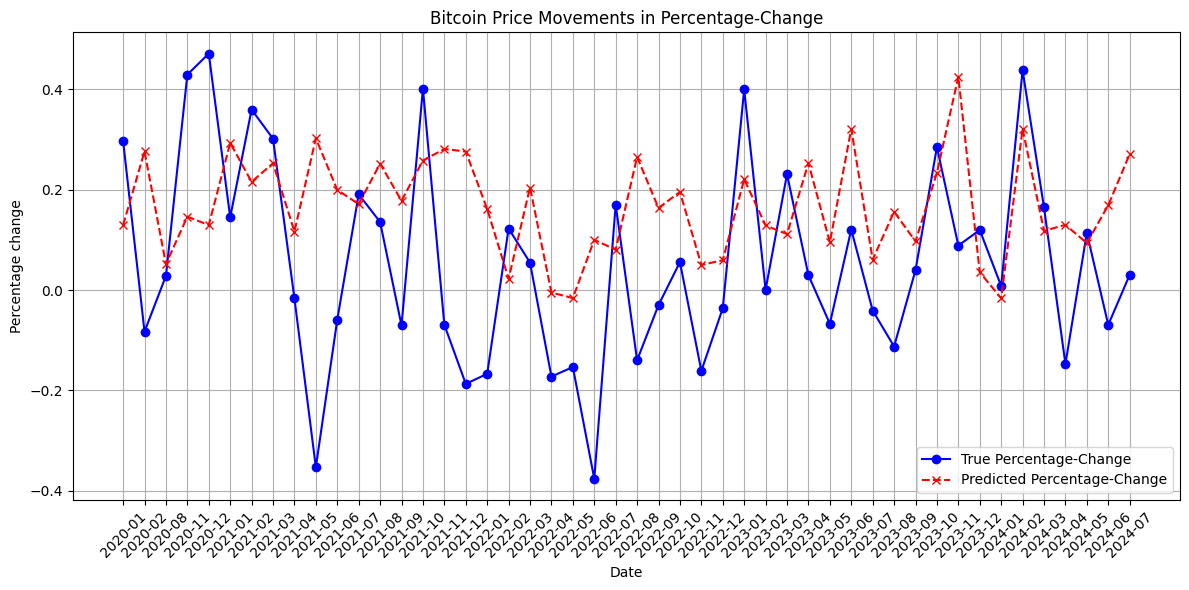

In [34]:
# Extract dates and values, ensuring both have the same months
common_months = set(true_prices.keys()).intersection(set(predictions.keys()))

# Filter out months that are not in both true_stocks and predictions
dates = sorted(list(common_months))  # Sort to ensure order
true_values = [true_prices[month] for month in dates]
predicted_values = [predictions[month] for month in dates]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dates, true_values, color='blue', marker='o', label='True Percentage-Change')
plt.plot(dates, predicted_values, color='red', marker='x', linestyle='--', label='Predicted Percentage-Change')

# Adding titles and labels
plt.title('Bitcoin Price Movements in Percentage-Change')
plt.xlabel('Date')
plt.ylabel('Percentage change')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Display plot
plt.tight_layout()
plt.show()

### Ethereum

In [35]:
crypto_news = {}

for month, news in training_data['ETH'].items():
    crypto_news[month] = [item['title'] for item in news]
        

true_prices={}
for month,price in price_history_data['ETH'].items():
    true_prices[month]=price['percentage_change']

In [36]:
predictions=predict_crypto_price(crypto_news)

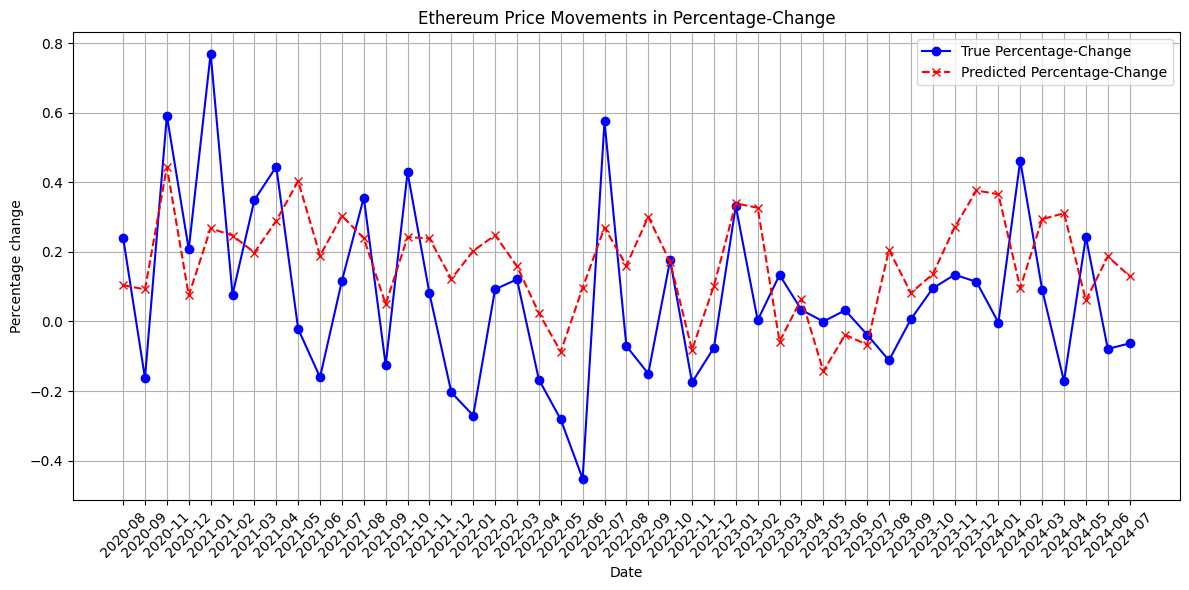

In [37]:
# Extract dates and values, ensuring both have the same months
common_months = set(true_prices.keys()).intersection(set(predictions.keys()))

# Filter out months that are not in both true_stocks and predictions
dates = sorted(list(common_months))  # Sort to ensure order
true_values = [true_prices[month] for month in dates]
predicted_values = [predictions[month] for month in dates]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dates, true_values, color='blue', marker='o', label='True Percentage-Change')
plt.plot(dates, predicted_values, color='red', marker='x', linestyle='--', label='Predicted Percentage-Change')

# Adding titles and labels
plt.title('Ethereum Price Movements in Percentage-Change')
plt.xlabel('Date')
plt.ylabel('Percentage change')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Display plot
plt.tight_layout()
plt.show()

### Binance Coin

In [38]:
crypto_news = {}

for month, news in training_data['BNB'].items():
    crypto_news[month] = [item['title'] for item in news]
        

true_prices={}
for month,price in price_history_data['BNB'].items():
    true_prices[month]=price['percentage_change']

In [39]:
predictions=predict_crypto_price(crypto_news)

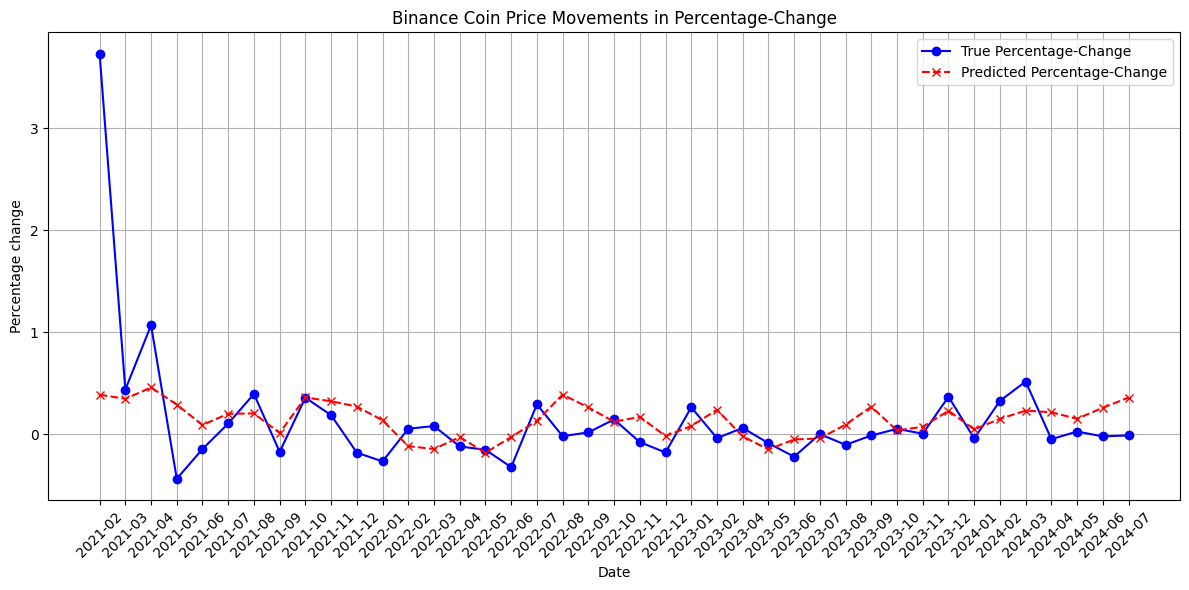

In [40]:
# Extract dates and values, ensuring both have the same months
common_months = set(true_prices.keys()).intersection(set(predictions.keys()))

# Filter out months that are not in both true_stocks and predictions
dates = sorted(list(common_months))  # Sort to ensure order
true_values = [true_prices[month] for month in dates]
predicted_values = [predictions[month] for month in dates]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dates, true_values, color='blue', marker='o', label='True Percentage-Change')
plt.plot(dates, predicted_values, color='red', marker='x', linestyle='--', label='Predicted Percentage-Change')

# Adding titles and labels
plt.title('Binance Coin Price Movements in Percentage-Change')
plt.xlabel('Date')
plt.ylabel('Percentage change')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Display plot
plt.tight_layout()
plt.show()

### Solana

In [41]:
crypto_news = {}

for month, news in training_data['SOL'].items():
    crypto_news[month] = [item['title'] for item in news]
        

true_prices={}
for month,price in price_history_data['SOL'].items():
    true_prices[month]=price['percentage_change']

In [42]:
predictions=predict_crypto_price(crypto_news)

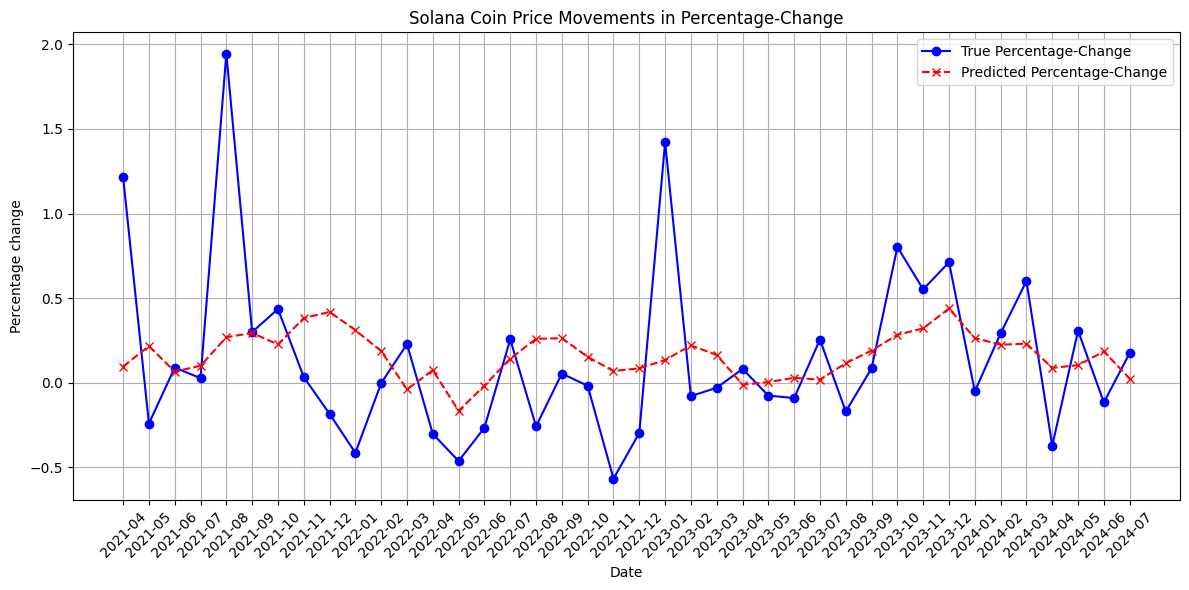

In [43]:
# Extract dates and values, ensuring both have the same months
common_months = set(true_prices.keys()).intersection(set(predictions.keys()))

# Filter out months that are not in both true_stocks and predictions
dates = sorted(list(common_months))  # Sort to ensure order
true_values = [true_prices[month] for month in dates]
predicted_values = [predictions[month] for month in dates]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dates, true_values, color='blue', marker='o', label='True Percentage-Change')
plt.plot(dates, predicted_values, color='red', marker='x', linestyle='--', label='Predicted Percentage-Change')

# Adding titles and labels
plt.title('Solana Coin Price Movements in Percentage-Change')
plt.xlabel('Date')
plt.ylabel('Percentage change')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Display plot
plt.tight_layout()
plt.show()

### Ripple

In [44]:
crypto_news = {}

for month, news in training_data['XRP'].items():
    crypto_news[month] = [item['title'] for item in news]
        

true_prices={}
for month,price in price_history_data['XRP'].items():
    true_prices[month]=price['percentage_change']

In [45]:
predictions=predict_crypto_price(crypto_news)

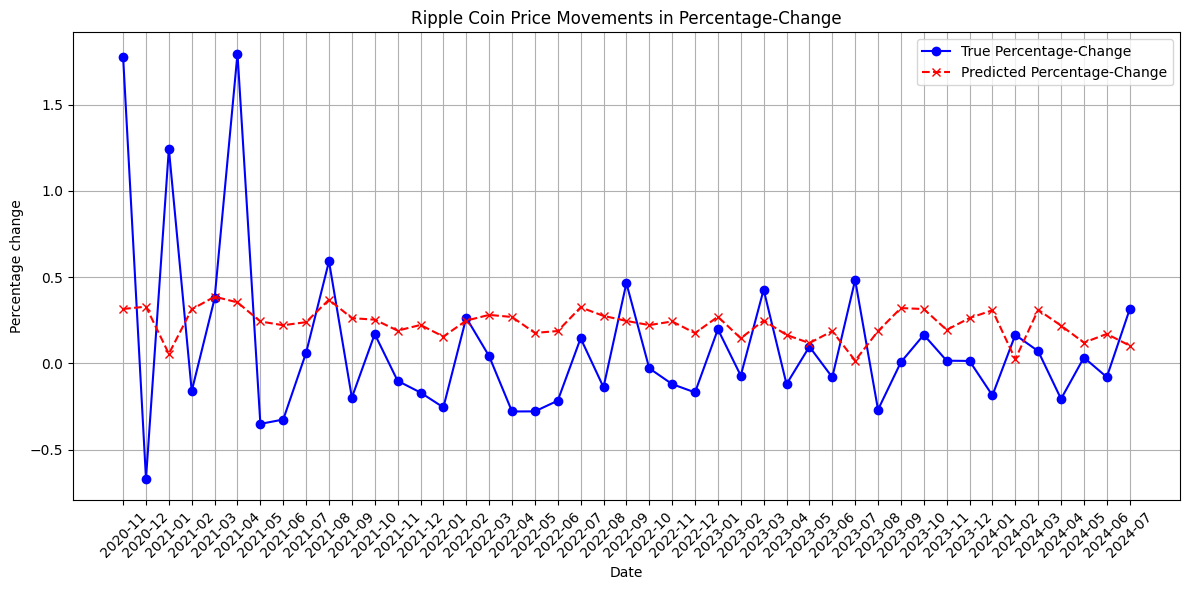

In [46]:
# Extract dates and values, ensuring both have the same months
common_months = set(true_prices.keys()).intersection(set(predictions.keys()))

# Filter out months that are not in both true_stocks and predictions
dates = sorted(list(common_months))  # Sort to ensure order
true_values = [true_prices[month] for month in dates]
predicted_values = [predictions[month] for month in dates]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dates, true_values, color='blue', marker='o', label='True Percentage-Change')
plt.plot(dates, predicted_values, color='red', marker='x', linestyle='--', label='Predicted Percentage-Change')

# Adding titles and labels
plt.title('Ripple Coin Price Movements in Percentage-Change')
plt.xlabel('Date')
plt.ylabel('Percentage change')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Display plot
plt.tight_layout()
plt.show()